# Scaling early and late

## Initialize data

In [106]:
import matplotlib.pyplot as plt
import nengo
import numpy as np
import tensorflow as tf
import nengo_dl

seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

In [107]:
# obtain images
(train_images, train_labels), (test_images,test_labels) = tf.keras.datasets.cifar10.load_data()

# one-hot encoding
# train_labels = tf.keras.utils.to_categorical(train_labels, 10)
# test_labels = tf.keras.utils.to_categorical(test_labels, 10)

# normalize data by color channel
def normalize(array):
    return (array - np.mean(array)) / np.std(array)

train_images_R = normalize(train_images.transpose()[0].transpose())
train_images_G = normalize(train_images.transpose()[1].transpose())
train_images_B = normalize(train_images.transpose()[2].transpose())
test_images_R = normalize(test_images.transpose()[0].transpose())
test_images_G = normalize(test_images.transpose()[1].transpose())
test_images_B = normalize(test_images.transpose()[2].transpose())

train_images = np.array([train_images_R, train_images_G, train_images_B])
test_images = np.array([test_images_R, test_images_G, test_images_B])

train_images = np.moveaxis(train_images, 0, -1)
test_images = np.moveaxis(test_images, 0, -1)

# verify normalization
print((train_images.shape, train_labels.shape), (test_images.shape, test_labels.shape))
print('test mean:', np.mean(train_images))
print('test stdv:', np.std(train_images))
print('train mean:', np.mean(test_images))
print('train stdv:', np.std(test_images))

((50000, 32, 32, 3), (50000, 1)) ((10000, 32, 32, 3), (10000, 1))
test mean: 5.4830214442821065e-17
test stdv: 1.0000000000000002
train mean: 8.14903700074865e-18
train stdv: 1.0000000000000002


In [108]:
# flatten images and add time dimension
train_images = train_images.reshape((train_images.shape[0], 1, -1))
train_labels = train_labels.reshape((train_labels.shape[0], 1, -1))
test_images = test_images.reshape((test_images.shape[0], 1, -1))
test_labels = test_labels.reshape((test_labels.shape[0], 1, -1))

print((train_images.shape, train_labels.shape), (test_images.shape, test_labels.shape))

((50000, 1, 3072), (50000, 1, 1)) ((10000, 1, 3072), (10000, 1, 1))


## Build convolutional network and convert to nengo-dl

In [109]:
inp = tf.keras.Input(shape=(32, 32, 3))

flatten = tf.keras.layers.Flatten()(inp)

dense0 = tf.keras.layers.Dense(units=100, activation=tf.keras.activations.relu)(flatten)
dense1 = tf.keras.layers.Dense(units=100, activation=tf.keras.activations.relu)(dense0)
dense2 = tf.keras.layers.Dense(units=100, activation=tf.keras.activations.relu)(dense1)
dense3 = tf.keras.layers.Dense(units=100, activation=tf.keras.activations.relu)(dense2)
# dense4 = tf.keras.layers.Dense(units=100, activation=tf.keras.activations.relu)(dense3)
# dense5 = tf.keras.layers.Dense(units=100, activation=tf.keras.activations.relu)(dense4)
# dense6 = tf.keras.layers.Dense(units=100, activation=tf.keras.activations.relu)(dense5)
# dense7 = tf.keras.layers.Dense(units=100, activation=tf.keras.activations.relu)(dense6)
# dense8 = tf.keras.layers.Dense(units=100, activation=tf.keras.activations.relu)(dense7)
out = tf.keras.layers.Dense(units=10)(dense3)

model = tf.keras.Model(inputs=inp, outputs=out)

In [110]:
converter = nengo_dl.Converter(model)

## Train the non-spiking network

In [111]:
with nengo_dl.Simulator(converter.net, minibatch_size=200) as sim:
    
    sim.compile(
        optimizer=tf.optimizers.Adam(0.001),
        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.metrics.sparse_categorical_accuracy]
    )

    sim.fit(
        {converter.inputs[inp]: train_images},
        {converter.outputs[out]: train_labels},
        validation_data=({converter.inputs[inp]: test_images}, {converter.outputs[out]: test_labels}),
        epochs=10
    )

    # save the parameters
    sim.save_params("./scaling_early_and_late_params")

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:01                                               
Epoch 1/10
250/250 [==============================] - 26s 74ms/step - loss: 1.8624 - probe_loss: 1.8624 - probe_sparse_categorical_accuracy: 0.3336 - val_loss: 1.5972 - val_probe_loss: 1.5972 - val_probe_sparse_categorical_accuracy: 0.4276
Epoch 2/10
250/250 [==============================] - 15s 60ms/step - loss: 1.5322 - probe_loss: 1.5322 - probe_sparse_categorical_accuracy: 0.4568 - val_loss: 1.5064 - val_probe_loss: 1.5064 - val_probe_sparse_categorical_accuracy: 0.4688
Epoch 3/10
250/250 [==============================] - 4s 17ms/step - loss: 1.4336 - probe_loss: 1.4336 - probe_sparse_categorical_accuracy: 0.4906 - val_loss: 1.4622 - val_probe_loss: 1.4622 - val_probe_sparse_categorical_accuracy: 0.4895
Epoch 4/10
250/250 [=====================

## Run the non-spiking network

In [114]:
def run_network(
    model,
    activation,
    params_file="scaling_early_and_late_params",
    n_steps=30,
    scale_firing_rates=1,
    synapse=None,
    n_test=400,
):
    # convert the keras model to a nengo network
    nengo_converter = nengo_dl.Converter(
        model,
        swap_activations={tf.keras.activations.relu: activation},
        scale_firing_rates=scale_firing_rates,
        synapse=synapse,
    )

    # get input/output objects
    nengo_input = nengo_converter.inputs[inp]
    nengo_output = nengo_converter.outputs[out]

    # repeat inputs for some number of timesteps
    tiled_test_images = np.tile(test_images[:n_test], (1, n_steps, 1))

    # set some options to speed up simulation
    with nengo_converter.net:
        nengo_dl.configure_settings(stateful=False)

    # build network, load in trained weights, run inference on test images
    with nengo_dl.Simulator(
        nengo_converter.net, minibatch_size=10, progress_bar=False
    ) as nengo_sim:
        nengo_sim.load_params(params_file)
        data = nengo_sim.predict({nengo_input: tiled_test_images})

    # compute accuracy on test data, using output of network on
    # last timestep
    predictions = np.argmax(data[nengo_output][:, -1], axis=-1)
    accuracy = (predictions == test_labels[:n_test, 0, 0]).mean()
    print(f" test accuracy: {100 * accuracy:.2f}%")

    return accuracy

In [113]:
run_network(
    model=model,
    activation=nengo.SpikingRectifiedLinear(), 
    n_steps=60,
    synapse=0.002,
    scale_firing_rates=20
)

SimulationError: Number of saved parameters in scaling_early_and_late_params (7) != number of variables in the model (5)

In [74]:
run_network(activation=nengo.RectifiedLinear(), n_steps=10)

 test accuracy: 48.00%


0.48

## Scale the firing rates for each layer at a time

In [94]:
print(type(model.layers[0]))

<class 'tensorflow.python.keras.engine.input_layer.InputLayer'>


In [93]:
for layer in model.layers:
    print(type(layer))
    break

<class 'tensorflow.python.keras.engine.input_layer.InputLayer'>


In [99]:
scale_firing_rates

{<tensorflow.python.keras.engine.input_layer.InputLayer at 0x121e375d198>: 20,
 <tensorflow.python.keras.layers.core.Flatten at 0x1203a912198>: 20,
 <tensorflow.python.keras.layers.core.Dense at 0x1203a9123c8>: 20,
 <tensorflow.python.keras.layers.core.Dense at 0x1203a912710>: 20,
 <tensorflow.python.keras.layers.core.Dense at 0x1203a912a58>: 20,
 <tensorflow.python.keras.layers.core.Dense at 0x1203a912da0>: 20,
 <tensorflow.python.keras.layers.core.Dense at 0x1203a906128>: 20,
 <tensorflow.python.keras.layers.core.Dense at 0x1203a906470>: 20,
 <tensorflow.python.keras.layers.core.Dense at 0x1203a9067b8>: 20,
 <tensorflow.python.keras.layers.core.Dense at 0x1203a906b00>: 20,
 <tensorflow.python.keras.layers.core.Dense at 0x1203a906e48>: 20,
 <tensorflow.python.keras.layers.core.Dense at 0x1203a9321d0>: 20,
 <tensorflow.python.keras.layers.core.Dense at 0x12022cd6390>: 300}

In [97]:
import copy

In [103]:
tf.keras.backend.clear_session()

In [102]:
base_scale_firing_rates = 20
special_scale_firing_rates = 300
synapse = 0.002
accuracy_list = []

global_scale_firing_rates = {layer:base_scale_firing_rates for layer in model.layers}

for layer in model.layers[-2:]:


    scale_firing_rates = copy.deepcopy(global_scale_firing_rates)
    scale_firing_rates[layer] = special_scale_firing_rates

    print("Scaled layer: " + layer._name)
    accuracy = run_network(
        model=model,
        activation=nengo.SpikingRectifiedLinear(),
        n_steps=60,
        synapse=synapse,
        scale_firing_rates=scale_firing_rates)      
    accuracy_list.append(accuracy)

Scaled layer: dense_50


KeyboardInterrupt: 

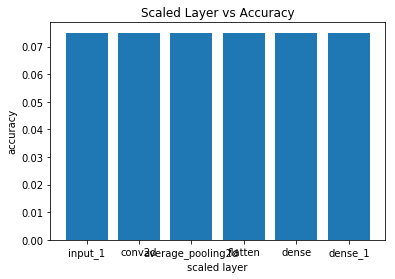

In [ ]:
accuracy_list = np.array(accuracy_list)
plt.xlabel("layer scaled")
plt.ylabel("accuracy")
plt.title("Layer Scaled vs Accuracy")
labels = [layer._name for layer in model.layers]
plt.bar(labels, accuracy_list)
plt.savefig("./scaling_early_and_late_output", dpi=300)